In [1]:
import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import auc_score, recall_at_k
import pandas as pd
import numpy as np

c:\Users\TeYang\AppData\Local\Programs\Python\Python39\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
PATH = '../../data/'
SEED = 2022

## Create LightFM Dataset -- Leave One Last
https://towardsdatascience.com/how-i-would-explain-building-lightfm-hybrid-recommenders-to-a-5-year-old-b6ee18571309

In [5]:
train = pd.read_csv(PATH + 'processed/' + 'train_lol.csv')[['userid', 'shop', 'rating']]
val = pd.read_csv(PATH + 'processed/' + 'val_lol.csv')[['userid', 'shop', 'rating']]
test = pd.read_csv(PATH + 'processed/' + 'test_lol.csv')[['userid', 'shop', 'rating']]

shop_features = pd.read_csv(PATH + 'processed/' + 'coffee_shops_context_long.csv')

In [6]:
shop_features

,alias,categories,price,region
0,nylon-coffee-roasters-singapore,coffeeroasteries,price$,Central
1,five-oars-coffee-roasters-singapore-2,coffeeroasteries,price$$,Central
2,the-wired-monkey-singapore-singapore,NaN,price$,Central
3,glasshouse-singapore,NaN,price$$,Central
4,tiong-hoe-specialty-coffee-singapore-3,coffeeroasteries,price$,Central
...,...,...,...,...
978,gallery-cafe-singapore,cafes,price$$,Central
979,new-station-snack-bar-singapore,cafes,price$$,Central
980,professor-brawn-cafe-singapore,cafes,price$,Central
981,ntuc-fairprice-singapore-60,NaN,price$,Central


In [8]:
shop_features['categories'].dropna().unique()

array(['coffeeroasteries', 'breakfast_brunch', 'sandwiches', 'cafes',
       'bakeries', 'desserts', 'bars', 'themedcafes', 'icecream',
       'juicebars'], dtype=object)

In [9]:
# get list of shop features
sf = []
features = list(shop_features.columns.drop('alias'))
for f in features:
    unique_cat = shop_features[f].dropna().unique()
    for cat in unique_cat: 
        sf.append(f + ':' + str(cat))
# for v in range(2):
#     for f in features:
#         sf.append(f + ':' + str(v))

sorted(sf)[:10]

['categories:bakeries',
 'categories:bars',
 'categories:breakfast_brunch',
 'categories:cafes',
 'categories:coffeeroasteries',
 'categories:desserts',
 'categories:icecream',
 'categories:juicebars',
 'categories:sandwiches',
 'categories:themedcafes']

In [11]:
train_dataset = Dataset()
train_dataset.fit(
    list(train['userid'].unique()),           # train has all users
    list(shop_features['alias'].unique()),    # train does not have all shops
    item_features= sf
)

In [12]:
# user-item interaction matrix
(interactions, weights) = train_dataset.build_interactions([(x[0], x[1], x[2]) for x in train.values])
(interactions_val, weights_val) = train_dataset.build_interactions([(x[0], x[1], x[2]) for x in val.values])
(interactions_test, weights_test) = train_dataset.build_interactions([(x[0], x[1], x[2]) for x in test.values])

In [28]:
# shop feature matrix
sf_tuple = []
for shop_idx,row in enumerate(shop_features.drop('alias',axis=1).values):
    sf_tuple.append((shop_features['alias'][shop_idx], [features[i] + ':' + str(col) for i,col in enumerate(row) if str(col) != 'nan']))
print(sf_tuple[0])

sf_mat = train_dataset.build_item_features(sf_tuple, normalize= False)

('nylon-coffee-roasters-singapore', ['categories:coffeeroasteries', 'price:price$', 'region:Central'])


In [51]:
user_id_map, user_feature_map, item_id_map, item_feature_map = train_dataset.mapping()

In [55]:
results = {}

for epoch in range(0,105,5):
      model = LightFM(loss='warp', random_state=SEED,)
      model.fit(
            interactions,
            item_features= sf_mat,
            sample_weight= weights,
            epochs=epoch,
            num_threads=4,
      )
      train_score = recall_at_k(
            model,
            interactions,
            item_features= sf_mat,
            k=5
      ).mean()

      val_score = recall_at_k(
            model,
            interactions_val,
            item_features= sf_mat,
            k=5
      ).mean()

      results[epoch] = (train_score, val_score)

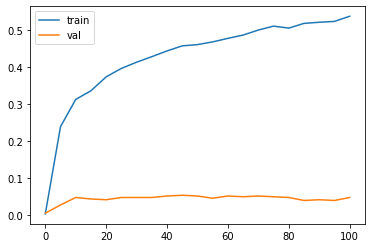

In [56]:
import matplotlib.pyplot as plt
plt.plot(*zip(*results.items()))
plt.legend(['train','val'])
plt.show()

In [73]:
model = LightFM(loss='warp', random_state=SEED)
model.fit(
    interactions,
    item_features= sf_mat,
    sample_weight= weights,
    epochs=25,
    num_threads=4
)

recall_at_k(
    model,
    interactions_test,
    item_features= sf_mat,
    k=5
).mean()

0.04225352112676056

In [74]:
len(train['userid'].unique())

497

In [75]:
preds = []
for user in train['userid'].unique():
    user_idx = user_id_map[user]
    n_users, n_items = interactions.shape 
    preds.append(model.predict(user_idx, np.arange(n_items)))

In [76]:
preds = np.array(preds)
preds_sort_idx = np.argsort(preds)
preds_sort_idx_20 = np.flip(preds_sort_idx[:,-20:], axis=1)
preds_sort_idx_20

array([[517, 110, 964, ..., 353, 435, 570],
       [ 64,  88,  28, ..., 211, 478, 280],
       [517, 941, 656, ..., 304, 827, 261],
       ...,
       [ 11, 969, 327, ..., 470, 282, 767],
       [310,  15, 668, ..., 130, 737, 221],
       [ 27, 517, 464, ..., 435, 175, 725]], dtype=int64)

In [78]:
idx_item_map = {v:k for k,v in item_feature_map.items()}
feature_embeddings = model.item_embeddings[interactions.shape[1]:]

In [87]:
top_cared_aspects=5

explanations = []
for i,user in enumerate(train['userid'].unique()):
    user_explanations = []
    for shop_idx in preds_sort_idx_20[i]:
        U = user
        S = shop_idx

        user2aspect_affinity = np.dot(feature_embeddings, model.user_embeddings[user_id_map[U]])
        user2aspect_affinity = np.argsort(user2aspect_affinity)[::-1][:top_cared_aspects]
        aspect_affinity_sorted = np.vectorize(idx_item_map.get)(user2aspect_affinity + interactions.shape[1])

        item2aspect_quality = np.dot(feature_embeddings, model.item_embeddings[S])
        item2aspect_quality = np.argsort(item2aspect_quality)[::-1]
        aspect_quality_sorted = np.vectorize(idx_item_map.get)(item2aspect_quality + interactions.shape[1])

        interested_aspect = aspect_quality_sorted[np.isin(aspect_quality_sorted, aspect_affinity_sorted)][0]
        user_explanations.append(interested_aspect)
    explanations.append(user_explanations)

In [88]:
explanations[0]

['region:Southeast',
 'categories:juicebars',
 'region:Southeast',
 'region:Southeast',
 'categories:sandwiches',
 'region:Southeast',
 'categories:sandwiches',
 'categories:juicebars',
 'categories:sandwiches',
 'categories:sandwiches',
 'region:Southeast',
 'region:Southeast',
 'region:Southeast',
 'region:Southeast',
 'categories:juicebars',
 'region:Southeast',
 'categories:juicebars',
 'categories:juicebars',
 'region:Southeast',
 'categories:sandwiches']

In [89]:
shop_rec = np.vectorize(idx_item_map.get)(preds_sort_idx_20)
shop_rec

array([['maxwell-food-centre-singapore-3', 'café-mosaic-singapore',
        'hong-lim-market-and-food-centre-singapore', ...,
        'bungy-bar-singapore', 'the-fabulous-baker-boy-singapore',
        'tiong-bahru-food-market-and-hawker-centre-singapore'],
       ['the-book-cafe-singapore', 'lau-pa-sat-singapore-2',
        'tiong-bahru-bakery-singapore-3', ...,
        'laurent-bernard-chocolatier-singapore',
        'ps-cafe-petit-singapore',
        'da-paolo-gastronomia-marina-bay-sands-singapore'],
       ['maxwell-food-centre-singapore-3',
        'old-airport-road-food-centre-singapore',
        'wimbly-lu-chocolate-cafe-company-singapore', ...,
        'waterfall-cafe-singapore', 'fika-singapore',
        'symmetry-singapore'],
       ...,
       ['chye-seng-huat-hardware-singapore', 'paul-singapore-3',
        'lolas-cafe-singapore', ..., 'toms-palette-singapore',
        'dal-komm-coffee-singapore', 'twg-tea-singapore-3'],
       ['jimmy-monkey-cafe-and-bar-singapore',
      

In [90]:
user_recs = pd.DataFrame.from_dict(dict(zip(train['userid'].unique(), shop_rec)), orient='index')
user_rec_exps = pd.DataFrame.from_dict(dict(zip(train['userid'].unique(), explanations)), orient='index')
user_recs.to_csv('../../results/outputs/lightFM_LOL_recommendations_improved_features.csv')
user_rec_exps.to_csv('../../results/outputs/lightFM_LOL_explanations_improved_features.csv')

In [91]:
user_recs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-5YMIME_WEin_by41Bj-3Q,maxwell-food-centre-singapore-3,café-mosaic-singapore,hong-lim-market-and-food-centre-singapore,old-airport-road-food-centre-singapore,pantler-singapore,guac-and-go-singapore,freshly-baked-by-le-bijoux-singapore,lau-pa-sat-singapore-2,old-hen-coffee-bar-singapore-2,meng-kitchen-singapore,wild-honey-singapore-3,tolidos-espresso-nook-singapore-3,koi-cafe-singapore-2,toast-box-singapore-24,hill-street-coffee-shop-singapore,the-bao-makers-singapore,wanna-cuppa-singapore,bungy-bar-singapore,the-fabulous-baker-boy-singapore,tiong-bahru-food-market-and-hawker-centre-sing...
-G1YjYxjDpxOBzFgo36ORA,the-book-cafe-singapore,lau-pa-sat-singapore-2,tiong-bahru-bakery-singapore-3,level33-singapore-4,nanyang-old-coffee-singapore,ps-cafe-singapore-8,common-man-coffee-roasters-singapore,boufe-boutique-cafe-singapore,spize-singapore-2,tiong-bahru-bakery-singapore-4,toms-palette-singapore,privé-café-singapore,twg-tea-on-the-bay-singapore,old-hen-coffee-bar-singapore-2,da-paolo-gastronomia-bukit-timah-bukit-timah,wild-honey-singapore-3,joe-and-dough-singapore-4,laurent-bernard-chocolatier-singapore,ps-cafe-petit-singapore,da-paolo-gastronomia-marina-bay-sands-singapore
-WShM_YFbtG4OcE0vrFVyw,maxwell-food-centre-singapore-3,old-airport-road-food-centre-singapore,wimbly-lu-chocolate-cafe-company-singapore,tiong-bahru-bakery-singapore-4,group-therapy-coffee-singapore,chye-seng-huat-hardware-singapore,hoshino-coffee-singapore,drips-singapore,strangers-reunion-singapore,penny-university-singapore,manicurious-singapore,the-bravery-cafe-singapore,the-fabulous-baker-boy-singapore,food-for-thought-singapore,hong-lim-market-and-food-centre-singapore,paul-singapore-3,nylon-coffee-roasters-singapore,waterfall-cafe-singapore,fika-singapore,symmetry-singapore
-XaIf12ricWc5z5BRt9nnQ,maxwell-food-centre-singapore-3,group-therapy-coffee-singapore,tobys-estate-singapore,tiong-bahru-bakery-singapore-4,the-bravery-cafe-singapore,wild-honey-singapore-3,strangers-reunion-singapore,chye-seng-huat-hardware-singapore,food-for-thought-singapore,oriole-coffee-bar-singapore-2,lau-pa-sat-singapore-2,cafe-melba-singapore,symmetry-singapore,the-orange-thimble-singapore,penny-university-singapore,level33-singapore-4,the-fabulous-baker-boy-singapore,old-airport-road-food-centre-singapore,hoshino-coffee-singapore,two-men-bagel-house-singapore
-fUWq6sOIEe1uTUhNKS9sQ,chye-seng-huat-hardware-singapore,paul-singapore-3,nylon-coffee-roasters-singapore,lolas-cafe-singapore,tiong-bahru-food-market-and-hawker-centre-sing...,tiong-bahru-bakery-singapore-4,the-assembly-ground-singapore,drips-singapore,fika-singapore,old-airport-road-food-centre-singapore,group-therapy-coffee-singapore,maxwell-food-centre-singapore-3,strangers-reunion-singapore,drury-lane-singapore,hoshino-coffee-singapore,spize-singapore-2,wimbly-lu-chocolate-cafe-company-singapore,twg-tea-singapore-3,kith-cafe-singapore,food-for-thought-singapore


In [92]:
user_rec_exps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-5YMIME_WEin_by41Bj-3Q,region:Southeast,categories:juicebars,region:Southeast,region:Southeast,categories:sandwiches,region:Southeast,categories:sandwiches,categories:juicebars,categories:sandwiches,categories:sandwiches,region:Southeast,region:Southeast,region:Southeast,region:Southeast,categories:juicebars,region:Southeast,categories:juicebars,categories:juicebars,region:Southeast,categories:sandwiches
-G1YjYxjDpxOBzFgo36ORA,region:Central,categories:juicebars,categories:juicebars,region:Central,categories:juicebars,price:price$$$,categories:cafes,categories:juicebars,categories:sandwiches,categories:sandwiches,price:price$$$,categories:sandwiches,categories:cafes,price:price$$$,price:price$$$,price:price$$$,categories:juicebars,region:Central,price:price$$$,categories:juicebars
-WShM_YFbtG4OcE0vrFVyw,region:Southeast,price:price$$$$,categories:bakeries,categories:coffeeroasteries,categories:coffeeroasteries,categories:bakeries,region:Southeast,price:price$$$$,categories:coffeeroasteries,region:Southeast,categories:bakeries,region:Southeast,categories:bakeries,categories:bakeries,region:Southeast,categories:bakeries,categories:coffeeroasteries,price:price$$$$,categories:bakeries,price:price$$$$
-XaIf12ricWc5z5BRt9nnQ,region:Southeast,categories:coffeeroasteries,categories:coffeeroasteries,categories:coffeeroasteries,region:Southeast,categories:breakfast_brunch,categories:coffeeroasteries,categories:coffeeroasteries,price:price$$$$,categories:coffeeroasteries,categories:breakfast_brunch,categories:coffeeroasteries,price:price$$$$,categories:coffeeroasteries,region:Southeast,categories:coffeeroasteries,price:price$$$$,price:price$$$$,region:Southeast,categories:coffeeroasteries
-fUWq6sOIEe1uTUhNKS9sQ,categories:bakeries,categories:bakeries,categories:coffeeroasteries,categories:bakeries,categories:sandwiches,categories:coffeeroasteries,categories:bakeries,price:price$$$$,categories:bakeries,price:price$$$$,categories:coffeeroasteries,price:price$$$$,categories:coffeeroasteries,categories:coffeeroasteries,price:price$$$$,categories:sandwiches,categories:bakeries,categories:bakeries,categories:sandwiches,categories:bakeries


In [103]:
# old-airport road price quality score
np.dot(model.item_embeddings[interactions.shape[1]:], model.item_embeddings[941])[10:14]

array([ 0.6017738 , -0.5135742 , -0.11732572,  1.0677679 ], dtype=float32)